# Zero-Sum 3x3 Grid Game

**Experiment Setup**:
- **Grid Size:** 3x3 (indices 0-2)
- **Agents:** Two agents, Agent A and Agent B
- **Initial positions:** Agent A starts at (0,0) and Agent B at (2,2)
- **Target Cell:** The center of the grid (1,1). This is the only winning cell
- **Simultaneous moves:** Both agent schose one of four actions [UP, DOWN, LEFT, RIGHT] at the same time
- **Terminal condition and rewards:**
    - The game ends when at least one agent reaches (1,1)
    - If only one agent reaches (1,1), taht agent wins +1 and the other loses -1
    - If both reach (1,1) simultaneously, Agent A wins (tie-breaker)
- **Zero-Sum:** One agent's gain is exactly the other's loss

**Unique Nash Equilibrium**:
This design (with asymmetric starting positions and a tie-breaker) guarantees that the unique Nash equilibrium is for both agents to head toword (1,1), with agent B unable to improve its outcome by deviating

In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

In [ ]:
grid_size = 3
max_steps = 30

In [ ]:
class GridGameZeroSum(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self):
        self.grid_size = grid_size
        self.max_steps = max_steps
        # Asymmetric starting positions to induce a unique equilibrium:
        # Both agents are equidistant (Manhattan distance 2) from the target.
        self.init_positions = [(0, 0), (2, 2)]  # Agent A at (0,0), Agent B at (2,2)
        # Target cell (center of the grid)
        self.target = (1, 1)
        
        # 4 discrete actions per agent: 0=UP, 1=DOWN, 2=LEFT, 3=RIGHT.
        self.action_space = spaces.MultiDiscrete([4, 4])
        
        # Observations: positions of both agents.
        self.observation_space = spaces.Dict({
            "agentA": spaces.Box(low=0, high=self.grid_size-1, shape=(2,), dtype=int),
            "agentB": spaces.Box(low=0, high=self.grid_size-1, shape=(2,), dtype=int)
        })
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agentA_pos, self.agentB_pos = self.init_positions
        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        return {
            "agentA": np.array(self.agentA_pos, dtype=int),
            "agentB": np.array(self.agentB_pos, dtype=int)
        }

    def step(self, actions):
        self.steps += 1

        # Calculate new positions given the actions.
        new_posA = self._move(self.agentA_pos, actions[0])
        new_posB = self._move(self.agentB_pos, actions[1])

        # Update positions simultaneously.
        self.agentA_pos = new_posA
        self.agentB_pos = new_posB

        rewardA = rewardB = 0
        done = False

        reached_A = (self.agentA_pos == self.target)
        reached_B = (self.agentB_pos == self.target)

        if reached_A or reached_B:
            done = True
            # If both agents reach the target simultaneously, apply tie‑breaker in favor of Agent A.
            if reached_A and reached_B:
                rewardA = 1
                rewardB = -1
            elif reached_A:
                rewardA = 1
                rewardB = -1
            elif reached_B:
                rewardA = -1
                rewardB = 1

        if self.steps >= self.max_steps:
            done = True

        return self._get_obs(), (rewardA, rewardB), done, {}, {}

    def _move(self, pos, action):
        x, y = pos
        if action == 0:  # UP
            x = max(0, x - 1)
        elif action == 1:  # DOWN
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # LEFT
            y = max(0, y - 1)
        elif action == 3:  # RIGHT
            y = min(self.grid_size - 1, y + 1)
        return (x, y)

    def render(self):
        # Create a simple textual grid for display.
        grid = np.full((self.grid_size, self.grid_size), '.', dtype='<U5')
        # Mark the target cell.
        grid[self.target] = 'T'
        aA = self.agentA_pos
        aB = self.agentB_pos
        if aA == aB:
            grid[aA] = 'A*'
        else:
            grid[aA] = 'A'
            grid[aB] = 'B'
        print("Current Grid:")
        for row in grid:
            print(" ".join(row))
        print()

## Nash Q-Learning Setup

We use a Nash Q-Learning learner (with NashPy) that treats the one-step stage game (given by the Q-tables) as a zero-sum game  When computing equilibria for each state (using support enumeration), we select the equilibrium that underpins the unique Nash equilibrium of this game.

The learner then is used to generate expert trajectories

In [8]:
import numpy as np
from nashpy import Game
import matplotlib.pyplot as plt

In [9]:
class NashQLearner:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.5, min_epsilon=0.01, decay_rate=0.0005):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.epsilon_history = []
        
        self.grid_size = env.grid_size
        # Q-tables with dimensions: agentA_x, agentA_y, agentB_x, agentB_y, agentA_action, agentB_action.
        self.QA = np.zeros((self.grid_size, self.grid_size,
                              self.grid_size, self.grid_size, 4, 4))
        # For a zero-sum game, the other Q-table is simply the negative.
        self.QB = -self.QA

    def decay_epsilon(self, episode):
        self.epsilon = max(self.min_epsilon, self.epsilon * np.exp(-self.decay_rate * episode))
        self.epsilon_history.append(self.epsilon)

    def get_action(self, state, explore=True):
        s = self._state_to_index(state)
        
        # Use the Q-values as the payoff matrices.
        game = Game(self.QA[s], self.QB[s])
        equilibria = list(game.support_enumeration())
        
        # If multiple equilibria exist, we print a warning (but our design should yield one).
        if len(equilibria) > 1:
            print(f"Multiple equilibria found at state {s}. Using the first one.")
        
        # With probability epsilon (or if no equilibrium was computed), take random actions.
        if (not equilibria) or (explore and np.random.rand() < self.epsilon):
            return np.random.randint(0, 4), np.random.randint(0, 4)
        
        piA, piB = equilibria[0]
        aA = np.random.choice(4, p=piA)
        aB = np.random.choice(4, p=piB)
        return aA, aB

    def update(self, state, actions, rewards, next_state):
        s = self._state_to_index(state)
        s_next = self._state_to_index(next_state)
        aA, aB = actions
        rA, rB = rewards
        
        game_next = Game(self.QA[s_next], self.QB[s_next])
        equilibria_next = list(game_next.support_enumeration())
        
        if not equilibria_next:
            nash_qA = 0
            nash_qB = 0
        else:
            piA_next, piB_next = equilibria_next[0]
            # Compute the Nash Q-values for the next state.
            nash_qA = np.sum(np.outer(piA_next, piB_next) * self.QA[s_next])
            nash_qB = np.sum(np.outer(piA_next, piB_next) * self.QB[s_next])
        
        self.QA[s][aA][aB] += self.alpha * (rA + self.gamma * nash_qA - self.QA[s][aA][aB])
        # For a zero-sum game, QB is the negative of QA.
        self.QB[s][aA][aB] = -self.QA[s][aA][aB]

    def _state_to_index(self, state):
        return (
            int(state["agentA"][0]), int(state["agentA"][1]),
            int(state["agentB"][0]), int(state["agentB"][1])
        )

    def plot_learning_curve(self, episode_rewards):
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(len(episode_rewards)), [r[0] for r in episode_rewards], label="Agent A")
        plt.plot(np.arange(len(episode_rewards)), [r[1] for r in episode_rewards], label="Agent B")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Learning Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

## Training Loop

We train the NashQLearner for a number of episodes. Because our game is short, zero-sum race to (1,1) (with a unique Nash equilibrium), the Nash Q-Learning should converge to the unique equilibrium strategies.

Then we sample expert trajectories using the learned (equilibrium) policy.

/Users/valeriacerciello/.pyenv/versions/3.13.2/lib/python3.13/site-packages/nashpy/algorithms/support_enumeration.py:260: RuntimeWarning: 
An even number of (16) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria found at state (0, 1, 2, 1). Using the first one.
Episode 000 | Avg Reward: Agent A: -1.00, Agent B: 1.00
Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria found at state (0, 0, 1, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria found at state (0, 0, 1, 2). Using the first one.
Multiple equilibria found at state (1, 0, 1, 2). Using the first one.
Multiple equilibria found at state (2, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 1, 2). Using the first one.
Multiple equilibria found at state

/Users/valeriacerciello/.pyenv/versions/3.13.2/lib/python3.13/site-packages/nashpy/algorithms/support_enumeration.py:260: RuntimeWarning: 
An even number of (12) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Multiple equilibria found at state (1, 0, 1, 2). Using the first one.
Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 1). Using the first one.
Multiple equilibria found at state (2, 0, 2, 0). Using the first one.
Multiple equilibria found at state (1, 0, 1, 0). Using the first one.
Multiple equilibria found at state (0, 0, 0, 0). Using the first one.
Multiple equilibria found at state (0, 0, 0, 0). Using the first one.
Multiple equilibria found at state (0, 1, 1, 0). Using the first one.
Multiple equilibria found at state (0, 1, 0, 0). Using the first one.
Multiple equilibria found at state (0, 1, 0, 0). Using the first one.
Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria found at state (0, 0, 1, 2). Using the first one.
Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria 

/Users/valeriacerciello/.pyenv/versions/3.13.2/lib/python3.13/site-packages/nashpy/algorithms/support_enumeration.py:260: RuntimeWarning: 
An even number of (8) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Multiple equilibria found at state (0, 2, 0, 2). Using the first one.
Multiple equilibria found at state (0, 2, 0, 2). Using the first one.
Multiple equilibria found at state (0, 1, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 1, 2). Using the first one.
Multiple equilibria found at state (1, 0, 1, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (1, 0, 0, 2). Using the first one.
Multiple equilibria found at state (1, 0, 1, 2). Using the first one.
Multiple equilibria found at state (2, 0, 0, 2). Using the first one.
Multiple equilibria found at state (1, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria 

/Users/valeriacerciello/.pyenv/versions/3.13.2/lib/python3.13/site-packages/nashpy/algorithms/support_enumeration.py:260: RuntimeWarning: 
An even number of (4) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 1, 0, 2). Using the first one.
Multiple equilibria found at state (0, 1, 1, 2). Using the first one.
Multiple equilibria found at state (0, 1, 0, 2). Using the first one.
Multiple equilibria found at state (0, 2, 0, 2). Using the first one.
Multiple equilibria found at state (0, 2, 0, 2). Using the first one.
Multiple equilibria found at state (0, 1, 0, 2). Using the first one.
Multiple equilibria found at state (0, 1, 1, 2). Using the first one.
Multiple equilibria found at state (0, 1, 0, 2). Using the first one.
Multiple equilibria found at state (0, 1, 1, 2). Using the first one.
Multiple equilibria found at state (0, 1, 0, 2). Using the first one.
Multiple equilibria found at state (0, 1, 1, 2). Using the first one.
Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria found at state (0, 0, 1, 2). Using the first one.
Multiple equilibria 

/Users/valeriacerciello/.pyenv/versions/3.13.2/lib/python3.13/site-packages/nashpy/algorithms/support_enumeration.py:260: RuntimeWarning: 
An even number of (18) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
/Users/valeriacerciello/.pyenv/versions/3.13.2/lib/python3.13/site-packages/nashpy/algorithms/support_enumeration.py:260: RuntimeWarning: 
An even number of (2) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Multiple equilibria found at state (1, 0, 1, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (1, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (1, 0, 1, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (1, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (1, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (1, 0, 0, 2). Using the first one.
Multiple equilibria found at state (1, 0, 0, 1). Using the first one.
Multiple equilibria found at state (1, 0, 0, 0). Using the first one.
Multiple equilibria 

/Users/valeriacerciello/.pyenv/versions/3.13.2/lib/python3.13/site-packages/nashpy/algorithms/support_enumeration.py:260: RuntimeWarning: 
An even number of (6) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 1, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (1, 0, 0, 2). Using the first one.
Multiple equilibria found at state (2, 0, 0, 1). Using the first one.
Multiple equilibria found at state (1, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria 

/Users/valeriacerciello/.pyenv/versions/3.13.2/lib/python3.13/site-packages/nashpy/algorithms/support_enumeration.py:260: RuntimeWarning: 
An even number of (14) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 2). Using the first one.
Multiple equilibria found at state (1, 0, 0, 2). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 1, 0, 0). Using the first one.
Multiple equilibria found at state (0, 1, 1, 0). Using the first one.
Multiple equilibria found at state (0, 1, 0, 0). Using the first one.
Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria found at state (0, 1, 2, 2). Using the first one.
Multiple equilibria found at state (0, 2, 2, 2). Using the first one.
Multiple equilibria found at state (0, 2, 2, 1). Using the first one.
Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (0, 0, 2, 2). Using the first one.
Multiple equilibria 

/Users/valeriacerciello/.pyenv/versions/3.13.2/lib/python3.13/site-packages/nashpy/algorithms/support_enumeration.py:260: RuntimeWarning: 
An even number of (10) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Multiple equilibria found at state (1, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 0, 0, 1). Using the first one.
Multiple equilibria found at state (0, 1, 0, 2). Using the first one.
Multiple equilibria 

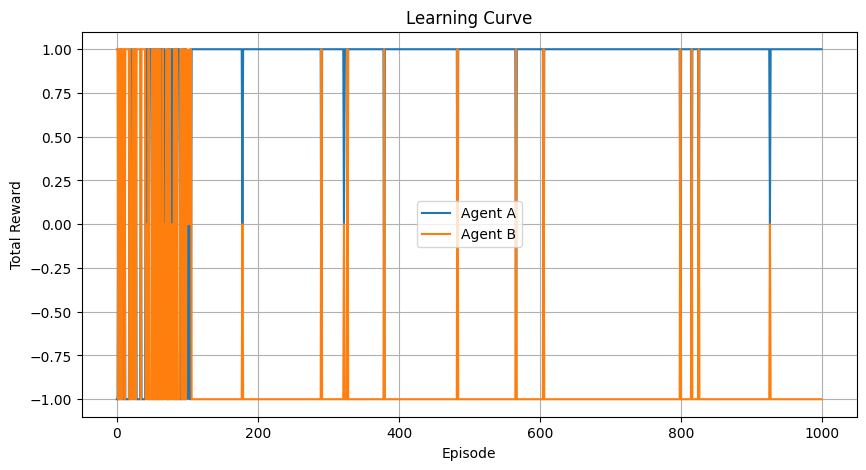

In [11]:
env = GridGameZeroSum()
agent = NashQLearner(env, alpha=0.1, gamma=0.99, epsilon=0.5)

all_episode_rewards = []
epsilon_decay = []
n_episodes = 1000


for episode in range(n_episodes):
    state, _ = env.reset()
    done = False
    total_reward = [0, 0]

    while not done:
        actions = agent.get_action(state)
        next_state, rewards, terminated, truncated, _ = env.step(actions)
        done = terminated or truncated

        agent.update(state, actions, rewards, next_state)
        state = next_state

        total_reward[0] += rewards[0]
        total_reward[1] += rewards[1]

    all_episode_rewards.append(total_reward)
    agent.decay_epsilon(episode)
    epsilon_decay.append(agent.epsilon)

    if episode % 50 == 0:
        avg_rewards = np.mean(all_episode_rewards[-50:], axis=0)
        print(f"Episode {episode:03d} | Avg Reward: Agent A: {avg_rewards[0]:.2f}, Agent B: {avg_rewards[1]:.2f}")

agent.plot_learning_curve(all_episode_rewards)

## Sampling Expert Trajectories

With the NashQLearner trained, we now generate expert trajectories (without exploration) by following the Nash equilibrium strategy at every state

In [12]:
def sample_expert_trajectories(agent, env, n_episodes=100):
    expert_trajectories = []

    for _ in range(n_episodes):
        episode = []
        obs, _ = env.reset()
        done = False

        while not done:
            actions = agent.get_action(obs, explore=False)
            next_obs, rewards, terminated, truncated, _ = env.step(actions)
            done = terminated or truncated

            step = {
                "obs": {
                    "agentA": obs["agentA"].copy(),
                    "agentB": obs["agentB"].copy()
                },
                "actions": actions,
                "next_obs": {
                    "agentA": next_obs["agentA"].copy(),
                    "agentB": next_obs["agentB"].copy()
                },
                "rewards": rewards,
                "done": done
            }
            episode.append(step)
            obs = next_obs

        expert_trajectories.append(episode)

    return expert_trajectories

def print_trajectories(trajectories, max_episodes=5):
    for ep_idx, episode in enumerate(trajectories[:max_episodes]):
        print(f"\n=== Trajectory {ep_idx + 1} ===")
        for t, step in enumerate(episode):
            obsA = tuple(step["obs"]["agentA"])
            obsB = tuple(step["obs"]["agentB"])
            aA, aB = step["actions"]
            rA, rB = step["rewards"]
            next_obsA = tuple(step["next_obs"]["agentA"])
            next_obsB = tuple(step["next_obs"]["agentB"])
            done = step["done"]

            print(f"Step {t:02d} | Obs: A:{obsA}, B:{obsB} | "
                  f"Actions: A={aA}, B={aB} | "
                  f"Rewards: A={rA}, B={rB} | "
                  f"Next: A:{next_obsA}, B:{next_obsB} | Done: {done}")

# Sample and print expert trajectories.
trajectories = sample_expert_trajectories(agent, env, n_episodes=20)
print_trajectories(trajectories, max_episodes=5)

Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria found at state (1, 0, 2, 2). Using the first one.
Multiple equilibria 